In [1]:
#CellStrat - Deep Learning tutorials

# Deep Learning Project: House-Boat Classifier using CNN
Preparation
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program has 10,000 training images
- This is a small program with 20 images of houses and 20 images of boats.
- The evaluation set has 10 images of houses and 10 images of boats


Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2 #Opencv
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [3]:
img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./house_boat/train'
testpath='./house_boat/test'
labels = {'house': 0, 'boat': 1}
fc_size=32 #size of the output of final FC layer
num_steps=5 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 39
X_data shape: (39, 32, 32, 3)
y_data shape: (39,)


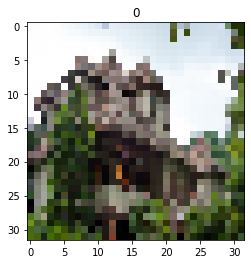

In [4]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])  #one column with 0 and 1
            #label_stack.append(one_hot_vector) #two columns with 1,0 or 0,1
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)
#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)
#print('y_data values',y_train)
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Plot Images

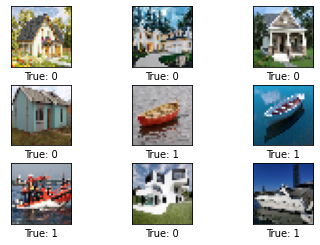

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    if len(images) == 0:
        print("no images to show")
        return
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))

    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])

    fig, axes = plt.subplots(3, 3)# Create figure with 3x3 sub-plots.
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        image= images[i].reshape(img_size, img_size, num_channels)
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        if cls_pred is None: # Show true and predicted classes.
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel) # Show the classes as the label on the x-axis.
        ax.set_xticks([]) # Remove ticks from the plot.
        ax.set_yticks([])
    plt.show()

# Plot some random images and their labels from the train set.
images, cls_true  = X_train, y_train
plot_images(images=images, cls_true=cls_true)

### Define the tensorflow model
The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training define the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial on TensorFlow website

In [6]:
def cnn_model_fn(features, labels, mode):

    input_layer = tf.reshape(features["x"], [-1, img_size, img_size, num_channels]) #Should we have 1 channel

    # Convolutional Layer #1 and  Pooling layer 1
    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # ---- Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(inputs=pool1,filters=256,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    # Dense Layer
    layer_shape = pool3.get_shape()
    num_features = layer_shape[1:4].num_elements()

    pool2_flat = tf.reshape(pool3, [-1, num_features])
    
    dense = tf.layers.dense(inputs=pool2_flat, units=fc_size, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    print('dense shape',dense.get_shape())

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    print('logits shape',logits.get_shape())
    print('labels shape',labels.get_shape())

    predictions = {"classes": tf.argmax(input=logits, axis=1),
                   "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:       
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


### Run the tensorflow model

In [7]:
#X_train_std = np.array((X_train/255.0),dtype=np.float16)
#X_test_std = np.array((X_test/255.0), dtype=np.float16)
X_train_std = np.array((X_train/255.0),dtype=np.float32)
X_test_std = np.array((X_test/255.0), dtype=np.float32)

house_boat_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/house_boat_convnet_model")

tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train_std}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
house_boat_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test_std}, y=y_test, num_epochs=1,shuffle=False)
eval_results = house_boat_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test_std}, num_epochs=1,shuffle=False)
predict_results = house_boat_classifier.predict(input_fn=predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/house_boat_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f917c5f82b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.rea